# Tanzanian water pumps
## A test of fast.ai vs XGBoost on tabular data
The Tanzanian Ministry of Water recently conducted a survey of tens of thousands of water pumps that had been installed around the country over the last several decades.  The Ministry knew what kind of pumps existed, which organizations had installed them, and how the pumps were managed.  The survey added one last important detail to the existing knowledge: did the pumps still work? 

The Ministry's data about the pumps and their status was collected into a dataset and organized into a competition by [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/), a platform that organizes data science competitions around problems with 
humanitarian impact.  Predictive analytics on this dataset could allow the Ministry to know in advance which pumps are most likely to be non-functional, so that they can triage their repair efforts.  It's hard to find much simpler examples of how a good predictive model can directly save time and money.

In this project, I use the [fast.ai](https://www.fast.ai/) deep learning library for one of its newest applications: predictive modeling on tabular data.  I compare its performance against the incumbent best tool in the field, gradient boosting with [XGBoost](https://xgboost.readthedocs.io/en/latest/). At least for this dataset, XGBoost achieves a higher accuracy and remains a system to be reckoned with.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import RobustScaler
pd.set_option('display.max_columns', None)  # Unlimited columns
from fastai.tabular import *

In [3]:
# I assume that you're running this notebook from inside a Docker container.
data_path = '/app/data/'

In [4]:
X_test = pd.read_csv(data_path + 'test_features.csv')
X_train = pd.read_csv(data_path + 'train_features.csv')
y_train = pd.read_csv(data_path + 'train_labels.csv')

# Data cleaning
This dataset required a few days of data cleaning and feature engineering.  There are many typos and problems with the data, lots of missing values, and several redundant or useless features. The following function encapsulates the end result.

In [5]:
def wrangle(X):
    """
    All-inclusive data cleanup.
    """
 
    # Make a clean copy, to ensure we're not changing the original DF
    X = X.copy()
    
    # Looking at all the features with missing values, it looks like those
    # features are all categorical variables where 'unknown' would be a
    # category we can work with.  I'll replace the NANs accordingly.
    X = X.fillna('unknown')
    
    # Regression on dates won't work.  Instead, I'll turn the 
    # date_recorded column into the number of years since 2000
    # (the earliest date in the training date is from ~2002, and the
    # latest from 2013.)
    dates = pd.to_datetime(X.date_recorded)
    year2000 = pd.to_datetime('2000-01-01')
    years = [i.days/365 for i in (dates - year2000)]
    X.date_recorded = years
    
    # region_code and district_code are int64, but they should really be
    # treated as categories (and there's only 20-30 classes in each).
    # I'll cast them as strings instead.
    X.region_code = X.region_code.astype('str')
    X.district_code = X.district_code.astype('str')
      
    # To prevent data conversion warnings, I'll turn all the numerical
    # features (except id) into float64.
    
    # Also, some columns contained bool values and NANs.  
    # (e.g., public_meeting, permit)
    # I replaced the NANs with strings, which created a problem for later
    # operations that don't like heterogeneous datatypes within a single
    # column. I'll prevent this problem by casting those two features as str.
    
    type_dict = {'amount_tsh':'float64',
                 'date_recorded':'float64',
                 'gps_height':'float64',
                 'longitude':'float64',
                 'latitude':'float64',
                 'num_private':'float64',
                 'population':'float64',
                 'construction_year':'float64',
                 'public_meeting':'str',
                 'permit':'str'}
    
    X = X.astype(dtype = type_dict)
    
    # Fixing the numerical columns.
    # ---------------------------------------------------------------    
    
    # Numerical columns have several kinds of garbage values that 
    # Must be replaced with nulls.
    numericals = ['amount_tsh',
                    'date_recorded',
                    'gps_height',
                    'longitude',
                    'latitude',
                    'num_private',
                    'population',
                    'construction_year']

    null_values = {'amount_tsh':0,
                     'date_recorded':0,
                     'gps_height':0,
                     'longitude':0,
                     'latitude':-2.000000e-08,
                     'num_private':0,
                     'population':0,
                     'construction_year':0}

    # I replace all garbage values with NANs.
    for feature, null in null_values.items():
        X[feature] = X[feature].replace(null, np.nan)
    
    # construction_year occasionally claims years far in the future, and 
    # could presumably also contain years way in the past.  I'll turn anything
    # not between 1960 and 2019 into a NAN.
    X['construction_year'] = [i if 1960 < i < 2019 else np.nan for i in X['construction_year']]

    
    # Whenever available, a good replacement value for a NAN is the 
    # mean or median value for the geographic region around it.

    # Replaces the NANs in a ward with the mean of the other rows in that 
    # same ward. If all the rows in a ward are NANs, though, they remain.
    for feature in numericals:
        replacements = X.groupby('ward')[feature].transform('mean')
        X[feature] = X[feature].fillna(replacements)

    # Replaces the NANs in a region with the mean of the other rows in that 
    # same region (which are much larger than wards)
    for feature in numericals:
        replacements = X.groupby('region')[feature].transform('mean')
        X[feature] = X[feature].fillna(replacements)
    
    # A few rows are not helped by averaging over the ward or the region.
    # Those can stay as they are, with NANs.
    
    # Fixing the categorical columns.
    # ---------------------------------------------------------------    
    
    # Create list of categorical features
    categoricals = X.select_dtypes(exclude='number').columns.tolist()

    # Make all strings lowercase, to collapse together some of the categories
    X[categoricals] = X[categoricals].applymap(lambda x: x.lower())

    # Replace common NAN values
    nan_list = ['not known','unknown','none','-','##','not kno','unknown installer']
    X = X.replace(nan_list, np.nan)

    # Any feature values with fewer than 50 rows gets turned into a NAN
    for feature in X[categoricals]:
        # Determine which feature values to keep
        to_keep = X[feature].value_counts()[X[feature].value_counts() > 50].index.tolist()
        # Turn those into NANs (using a copy, to prevent warnings)
        feature_copy = X[feature].copy()
        feature_copy[~feature_copy.isin(to_keep)] = np.nan
        X[feature] = feature_copy
    
    
    garbage = ['id','extraction_type_group','extraction_type_class',
               'region_code','waterpoint_type_group','source_type',
              'payment_type','quality_group','quantity_group',
              'recorded_by']
    
    X = X.drop(columns=garbage)
    
    X['age'] = X['date_recorded'] - X['construction_year']
    
    return X

In [6]:
# Apply to all our data
X_train = wrangle(X_train)
X_test = wrangle(X_test)

# Maps
Once the data has been cleaned, it's possible to map out the locations of all the water pumps in our training dataset. This doesn't affect the predictive models, but it does allow us to visually inspect for patterns and demonstrates the geopandas API.

In [8]:
import geopandas
def make_geodf(df, lat_col_name='latitude', lon_col_name='longitude'):
    """
    Take a dataframe with latitude and longitude columns, and turn
    it into a geopandas df.
    """
    from geopandas import GeoDataFrame
    from geopandas import points_from_xy
    df = df.copy()
    lat = df['latitude']
    lon = df['longitude']
    return GeoDataFrame(df, geometry=points_from_xy(lon, lat))

# Create mappable dataframe
train_geo = make_geodf(X_train)

# Add a column for colors to map
train_geo['colors'] = y_train.status_group.map({'functional':'xkcd:blue',
                         'non functional':'xkcd:goldenrod',
                         'functional needs repair':'xkcd:green'}).values

# Create maps of Tanzania and neighboring countries
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
tanzania = world[world.name == 'Tanzania']
neighbors = world[world.name.isin(['Uganda','Kenya','Rwanda','Burundi',
                                   'Dem. Rep. Congo',
                                   'Zambia','Malawi','Mozambique'])]

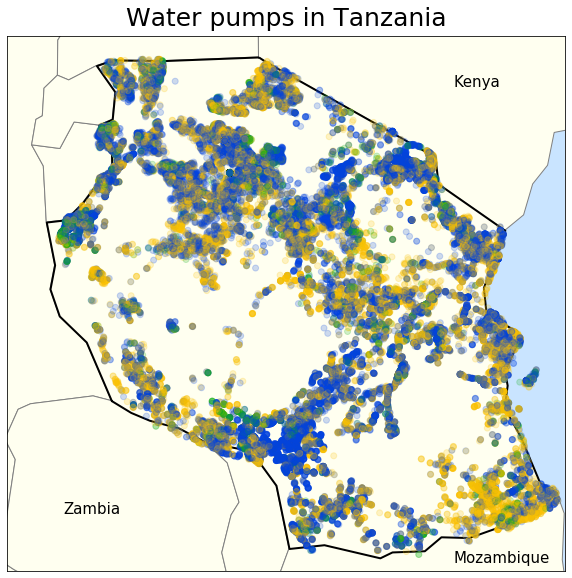

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor('#c9e4ff')
neighbors.plot(ax=ax, color='ivory', edgecolor='grey');
tanzania.plot(ax=ax, color='ivory', edgecolor='black', linewidth=2);

ax.set_xlim(28.5,40.5)
ax.set_ylim(-12, -0.5)
ax.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

# df = train_geo.sample(10)  # Uncomment to draw just a few datapoints
df = train_geo               # Uncomment to draw full dataset
df.plot(ax=ax, c=df['colors'], alpha=0.2);

neighbor_names = [
    ('Zambia', 0.1, 0.1),
    ('Kenya', 0.8, 0.9),
    ('Mozambique', 0.8, 0.01)]

for country in neighbor_names:
    s = country[0]
    x = country[1]
    y = country[2]

    ax.text(x, y, s,
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='black', fontsize=15);

ax.set_title('Water pumps in Tanzania', fontsize=25, pad=10);

# Fast.ai tabular model

I tested several variations for fitting a fast.ai tabular model, including two different hidden layer sizes and both the default and custom sizes for the embeddings. I ran fitting functions with a handful of learning rates until they all overfit, then used cached models to roll-back the overfitting. Since all of these variations resulted in about the same results, I present a single progression below.

In [23]:
# fast.ai expects our training data to contain independent values ('y') as well.
train = X_train.copy()
train['y'] = y_train['status_group']

Create TabularDataBunch with all the training, validation, and test data.

In [24]:
# Lists of column names
dep_var = 'y'
cat_names = X_train.select_dtypes(exclude='number').columns.tolist()
cont_names = X_train.select_dtypes('number').columns.tolist()

# Transformations
procs = [FillMissing, Categorify, Normalize] 

# A test set for the final predictions
test = TabularList.from_df(X_test, 
                           cat_names=cat_names, 
                           cont_names=cont_names)

# Training and validation data.  I validate on the last 59,400 data points
# and use everything else for training.  Note that this TabularDataBunch
# ('data') contains training and validation data (obtained from 'train'),
# and also test data once I add that.
data = (TabularList.from_df(train, 
                            cat_names=cat_names, 
                            cont_names=cont_names, 
                            procs=procs)
                           .split_by_idx(list(range(50000,59400)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

Fast.ai creates embeddings for all the categorical variables, grouping them so that the similarities between category members can be exploited. I set the embeddings to half the size of each variable's cardinality, up to a max of 50. This is a rule of thumb presented in the fast.ai courses, which overrides the library's default embedding size.

In [13]:
categories = X_train_processed[cat_names].nunique().keys().to_list()
cardinalities = X_train_processed[cat_names].nunique().values
emb_szs = {cat: min(50, card//2) for cat, card in zip(categories, cardinalities)}
emb_szs

{'funder': 50,
 'installer': 50,
 'wpt_name': 18,
 'basin': 4,
 'subvillage': 30,
 'region': 10,
 'district_code': 9,
 'lga': 50,
 'ward': 50,
 'public_meeting': 1,
 'scheme_management': 6,
 'scheme_name': 43,
 'permit': 1,
 'extraction_type': 8,
 'management': 6,
 'management_group': 2,
 'payment': 3,
 'water_quality': 3,
 'quantity': 2,
 'source': 5,
 'source_class': 1,
 'waterpoint_type': 3,
 'num_private_na': 1}

I create a tabular learner with relatively large layers, modeled after the architecture that was used to earn the third place in the Rossman Kaggle competition ([link](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb)). I regularize the model using dropouts for all layers and embeddings.

In [47]:
learn = tabular_learner(data, emb_szs=emb_szs, layers=[1000,500], 
                        ps=[0.001,0.01], metrics=accuracy, emb_drop=0.04)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(143, 50)
    (1): Embedding(126, 50)
    (2): Embedding(36, 18)
    (3): Embedding(10, 4)
    (4): Embedding(61, 30)
    (5): Embedding(22, 10)
    (6): Embedding(18, 9)
    (7): Embedding(124, 50)
    (8): Embedding(309, 50)
    (9): Embedding(3, 1)
    (10): Embedding(12, 6)
    (11): Embedding(87, 43)
    (12): Embedding(3, 1)
    (13): Embedding(16, 8)
    (14): Embedding(12, 6)
    (15): Embedding(5, 2)
    (16): Embedding(7, 3)
    (17): Embedding(7, 3)
    (18): Embedding(5, 2)
    (19): Embedding(10, 5)
    (20): Embedding(3, 1)
    (21): Embedding(7, 3)
    (22): Embedding(3, 1)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=365, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.

In [48]:
learn.save('1000-500-fresh')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


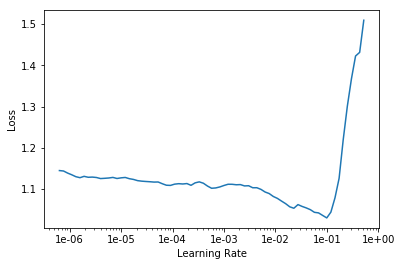

In [28]:
# I determine the best learning rate by finding the steepest downward slope before the 
# graph of loss-versus-lr diverges. In this case, I chose 1e-2.
learn.lr_find()
learn.recorder.plot()

I fit the model until it started overfitting, at the point when the validation loss started going up again.  Since fitting was relatively fast, I started again with slower steps and saved the model after 5 epochs.

In [29]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.603100,0.598857,0.754468,00:10
1,0.596605,0.583666,0.757340,00:11
2,0.574523,0.560102,0.773936,00:11
3,0.559919,0.546155,0.778192,00:11
4,0.536715,0.538945,0.782979,00:10
5,0.510305,0.576241,0.780745,00:11
6,0.488233,0.560490,0.790426,00:11
7,0.469493,0.540226,0.795000,00:11
8,0.445577,0.537415,0.796915,00:11
9,0.423417,0.525479,0.796702,00:11


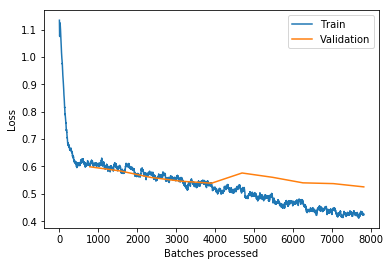

In [30]:
learn.recorder.plot_losses()

In [49]:
learn.load('1000-500-fresh')
learn.fit_one_cycle(5, max_lr=1e-2)
learn.save('1000-500-5cycles')

epoch,train_loss,valid_loss,accuracy,time
0,0.629175,0.614797,0.739787,00:11
1,0.582500,0.555476,0.771489,00:11
2,0.545684,0.537219,0.779468,00:11
3,0.517010,0.519902,0.789894,00:11
4,0.480589,0.518854,0.788191,00:11


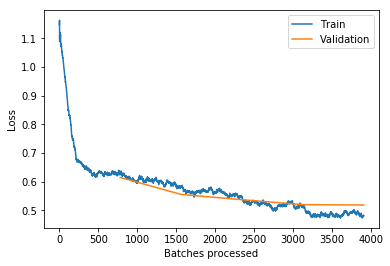

In [50]:
learn.recorder.plot_losses()

I fit for a few more epochs, and noted that the validation loss still dropped a bit under the previous level. A third batch of fitting (not shown) showed no improvement.

In [52]:
learn.fit_one_cycle(3, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.535637,0.538864,0.784362,00:11
1,0.519382,0.524623,0.787553,00:11
2,0.483919,0.513784,0.792447,00:11


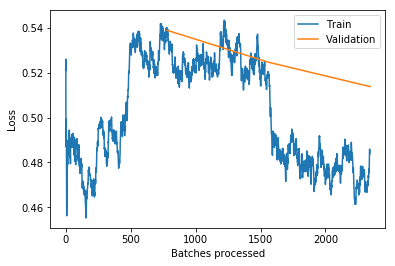

In [53]:
learn.recorder.plot_losses()

In [ ]:
learn.save('1000-500-8cycles')

The best accuracy I could get out of this model was `79.2%`.

# xgboost

In [11]:
# This function retrieves (as a dataframe) data from a tabular LabelList that has 
# already been normalized/imputed in earlier processing steps.
def get_proc_df(tll):
    """Get processed xs and ys from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    # Reconstruct ys to apply log if specified
    y_vals = np.array([i.obj for i in tll.y])
    return x_df, y_vals

In [12]:
# Normalized, imputed datasets
X_train_processed, y_train_processed = get_proc_df(data.train_ds)
X_valid_processed, y_valid_processed = get_proc_df(data.valid_ds)

In [145]:
from xgboost import XGBClassifier

modelxgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', 
                         nrounds = 'min.error.idx', num_class = 3, 
                         maximize = False, eval_metric = 'merror', eta = .1,
                         max_depth = 14, colsample_bytree = .4, n_jobs=-1)

In [146]:
%%time
modelxgb.fit(X_train_processed, y_train_processed)

CPU times: user 1min 3s, sys: 5.37 s, total: 1min 8s
Wall time: 44.1 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.1,
              eval_metric='merror', gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=14, maximize=False,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nrounds='min.error.idx', nthread=None, num_class=3,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [153]:
from sklearn.metrics import accuracy_score
y_pred = modelxgb.predict(X_valid_processed)
score = accuracy_score(y_valid_processed, y_pred)
score

0.8181914893617022

`81.8%` on the same dataset!  Contest is over.

# Export results
In order to test these predictions against the held-out dataset on DrivenData, we must create a submission file matching the format of the example. 

In [ ]:
# Export answers
test_preds=learn.get_preds(DatasetType.Test)
pred_numerical = [np.argmax(x).item() for x in test_preds[0]]
y_test = [learn.data.classes[x] for x in pred_numerical]

submission = pd.read_csv(data_path + 'sample_submission.csv')
submission['status_group'] = y_test

# submission.to_csv('answers.csv', index=False)   # Uncomment to save 